In [1]:
import sys # for automation and parallelisation
manual, scenario = (True, 'base') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])
if manual:
    %matplotlib inline

In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none func

In [2]:
import numpy as np
import pandas as pd
from quetzal.model import stepmodel
import matplotlib.pyplot as plt

# Logit model step
## Needs LoS tables and calibration parameters
## Saves logit probabilities and utilities

In [3]:
input_path = '../input/'
output_path = '../output/'
model_path = '../model/'

In [4]:
sm = stepmodel.read_json(model_path + 'de_pt_los')
car = stepmodel.read_json(model_path + 'de_road_los')

In [5]:
# Scale time to hours
if sm.pt_los['time'].mean() > 3600:
    sm.pt_los['time'] = sm.pt_los['time'] / 3600
elif sm.pt_los['time'].mean() < 10/3600:
    sm.pt_los['time'] = sm.pt_los['time'] * 3600
sm.pt_los['time'].mean()

5.650460207815043

In [6]:
if car.car_los['time'].mean() > 3600:
    car.car_los['time'] = car.car_los['time'] / 3600
car.car_los['time'].mean()

4.372604589221392

In [7]:
# Define route types for the choice tree
route_types = ['rail',#'rail_long', 'rail_short',
               'bus',#'coach', 'bus',
               'air','car', 'walk']

In [8]:
# Aggregate route types rail and road PT
type_dict = {'rail_long': 'rail', 'rail_short': 'rail', 'rail': 'rail',
             'coach': 'bus', 'bus': 'bus',
             'air': 'air', 'car': 'car', 'walk': 'walk'}
assert set(route_types).issubset(set(type_dict.keys()))
if 'rail_short' in sm.pt_los['route_type']:
    sm.pt_los['route_type_disagg'] = sm.pt_los['route_type'].copy()
sm.pt_los['route_type'] = sm.pt_los['route_type'].map(type_dict)

In [9]:
sm.pt_los.sample()

,access_time,accessibility,destination,footpath_time,in_vehicle_time,length,link_path,mode_utility,ntransfers,origin,...,"(""('Fz1', 0)"", 'probability')","(""('Fz1', 1)"", 'probability')","(""('Fz2', 0)"", 'probability')","(""('Fz2', 1)"", 'probability')","(""('Fz3', 0)"", 'probability')","(""('Fz3', 1)"", 'probability')","(""('Fz4', 0)"", 'probability')","(""('Fz4', 1)"", 'probability')","(""('Fz6', 0)"", 'probability')","(""('Fz6', 1)"", 'probability')"
index,,,,,,,,,,,,,,,,,,,,,
371016,1553,NaN,DE24C,954,15300,609824,"[rs_20859, rs_20860, rs_20861, rs_20862, bus_2...",-3.688621,7,DE936,...,0.000009,0.00028,0.0,0.000002,0.000002,0.000068,0.00242,0.026147,0.000001,0.004434


In [10]:
# Create LoS table
sm.los = pd.concat([sm.pt_los, car.car_los])
sm.los.reset_index(drop=True, inplace=True)
len(sm.los)

845582

In [11]:
sm.los.drop([col for col in sm.los.columns if col.startswith('(')],
            axis=1, inplace=True, errors='ignore')

In [12]:
# Clean LoS table
sm.los = sm.los.loc[sm.los['time']>0]
sm.los = sm.los.loc[sm.los['length']<=1000000]
len(sm.los)

845564

In [13]:
# Make route types hashable
sm.los['route_types'] = sm.los['route_types'].apply(tuple)

## Prepare the logit model

Load parameters and generate LoS columns

In [14]:
# Transport demand segments: the cartesian product of
# trip purposes and car ownership
segments_tuple = [('Fz'+str(p), car) for p in [1,2,3,4,6] for car in [0,1]]
# Convert tuple segments to strings in order to prevent issues
segments = [str(seg) for seg in segments_tuple]

In [15]:
# Create a column for generalised cost, see cal20
vot = pd.read_csv(input_path + 'vot.csv', header=[0,1], index_col=0).to_dict()
m_dict = {'rail_long': 'PT', 'rail_short': 'PT', 'rail': 'PT',
          'coach': 'PT', 'bus': 'PT', 'air': 'air', 'car': 'car'}
'''# Take averages over distances
vot = {('Fz1', 'PT'): 4.47, ('Fz1', 'air'): 33.67, ('Fz1', 'car'): 4.87,
       ('Fz2', 'PT'): 4.39, ('Fz2', 'air'): 33.67, ('Fz2', 'car'): 3.9,
       ('Fz3', 'PT'): 5.11, ('Fz3', 'air'): 33.67, ('Fz3', 'car'): 4.29,
       ('Fz4', 'PT'): 7.01, ('Fz4', 'air'): 38.76, ('Fz4', 'car'): 8.5,
       ('Fz6', 'PT'): 4.35, ('Fz6', 'air'): 25.45, ('Fz6', 'car'): 4.35}'''
'''# Take the same VoT for every segment
sm.los['gc'] = sm.los['time'] + [c / vot['root', m_dict[m]][int(d/1000)]
    if m!='walk' else 0 for c,d,m in zip(sm.los['price'], sm.los['length'], sm.los['route_type'])]
'''
# Take segment-specific VoT
for s in segments_tuple:
    sm.los[(str(s), 'gc')] = sm.los['time'] + [c / vot[s[0], 'all'][int(d/1000)] # m_dict[m] for mode-specific instead of all
        if m!='walk' else 0 for c,d,m in zip(
            sm.los['price'], sm.los['length'], sm.los['route_type'])]

In [16]:
# Load estimation results
excel = pd.ExcelFile(input_path + 'estimation_results_car_own.xls')
params_est = []
for segment in range(2, len(segments)+2): # First two sheets are all purposes
    df = excel.parse(segment)
    params_est.append(df.set_index(df.columns[0]))

In [17]:
# The nested logit structure can be set for each segment
# It must be the same as in the estimation
segs = segments + ['root']
col = ['root']*len(route_types) + [np.nan] #['pt']*(len(route_types)-3) + ['root']*4 + [np.nan]
nests = pd.DataFrame(index=route_types+['root'], #['pt', 'root'],
                     data={s: col for s in segments})
nests.index.name = 'route_type'
nests.columns.name = 'segment'
sm.mode_nests = nests
sm.mode_nests

segment,"('Fz1', 0)","('Fz1', 1)","('Fz2', 0)","('Fz2', 1)","('Fz3', 0)","('Fz3', 1)","('Fz4', 0)","('Fz4', 1)","('Fz6', 0)","('Fz6', 1)"
route_type,,,,,,,,,,
rail,root,root,root,root,root,root,root,root,root,root
bus,root,root,root,root,root,root,root,root,root,root
air,root,root,root,root,root,root,root,root,root,root
car,root,root,root,root,root,root,root,root,root,root
walk,root,root,root,root,root,root,root,root,root,root
root,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
# phi/theta values for each mode and nest come from calibration data
sm.logit_scales = pd.DataFrame(index=route_types, data={seg: 1 for seg in segments})
sm.logit_scales.loc['root'] = [1 for _ in range(len(segments))]
# For the nested structure
#sm.logit_scales.loc['pt'] = [1 / params_est[i].loc['mu_pt', 'Value']
#                             for i in range(len(segments))]
sm.logit_scales

,"('Fz1', 0)","('Fz1', 1)","('Fz2', 0)","('Fz2', 1)","('Fz3', 0)","('Fz3', 1)","('Fz4', 0)","('Fz4', 1)","('Fz6', 0)","('Fz6', 1)"
rail,1,1,1,1,1,1,1,1,1,1
bus,1,1,1,1,1,1,1,1,1,1
air,1,1,1,1,1,1,1,1,1,1
car,1,1,1,1,1,1,1,1,1,1
walk,1,1,1,1,1,1,1,1,1,1
root,1,1,1,1,1,1,1,1,1,1


In [19]:
# Initial values are the alternative specific constants (ASC) from calibration
sm.mode_utility = pd.DataFrame({seg: [] for seg in segments})
for t, asc in [('rail', 'asc_rail'),
#               ('rail_short', 'asc_rail_s'),
#               ('rail_long', 'asc_rail_l'),
#               ('coach', 'asc_coach'),
               ('bus', 'asc_road'),
               ('air', 'asc_air'), ('car', 0),
               ('walk', 'asc_non_motor'),('root', 0)]:
    sm.mode_utility.loc[t] = [params_est[i].loc[asc, 'Value']
                              if isinstance(asc, str) else asc
                              for i in range(len(segments))]
sm.mode_utility

,"('Fz1', 0)","('Fz1', 1)","('Fz2', 0)","('Fz2', 1)","('Fz3', 0)","('Fz3', 1)","('Fz4', 0)","('Fz4', 1)","('Fz6', 0)","('Fz6', 1)"
rail,3.610786,-1.859934,3.024309,-0.453534,3.089143,-2.989211,1.920800,-2.454182,3.617064,-2.670818
bus,2.401989,-3.393331,2.815849,-0.572806,2.437816,-3.731784,0.247491,-3.894269,2.403007,-3.574698
air,-5.763232,-8.743982,-6.103438,-9.515061,-6.729756,-6.416419,-0.781516,-3.490782,-6.848487,-4.142242
car,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
walk,-0.266398,-5.415253,0.263700,-3.155103,1.202666,-4.633924,-1.403479,-4.908446,0.828425,-4.227383
root,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [20]:
# Performance attributes for mode choice
#perf_attrs = ['gc_d']#, 'accessibility']
perf_attrs = [(s, 'gc_d') for s in segments]

In [21]:
# Beta parameters from calibration data
# IMPORTANT: watch the conversion
sm.utility_values = pd.DataFrame({seg: [0]*len(perf_attrs)
                                  for seg in segments}, index=perf_attrs)
sm.utility_values.loc['mode_utility'] = [1 for seg in segments]
for a,s in zip(perf_attrs, segments):
    sm.utility_values.loc[a, s] = params_est[segments.index(s)].loc['b_gc', 'Value']
sm.utility_values

,"('Fz1', 0)","('Fz1', 1)","('Fz2', 0)","('Fz2', 1)","('Fz3', 0)","('Fz3', 1)","('Fz4', 0)","('Fz4', 1)","('Fz6', 0)","('Fz6', 1)"
"(('Fz1', 0), gc_d)",-0.053499,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
"(('Fz1', 1), gc_d)",0.000000,-0.53297,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
"(('Fz2', 0), gc_d)",0.000000,0.00000,-0.775743,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
"(('Fz2', 1), gc_d)",0.000000,0.00000,0.000000,-0.264194,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
"(('Fz3', 0), gc_d)",0.000000,0.00000,0.000000,0.000000,-0.162611,0.000000,0.000000,0.000000,0.000000,0.000000
"(('Fz3', 1), gc_d)",0.000000,0.00000,0.000000,0.000000,0.000000,-0.369984,0.000000,0.000000,0.000000,0.000000
"(('Fz4', 0), gc_d)",0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,-0.188026,0.000000,0.000000,0.000000
"(('Fz4', 1), gc_d)",0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.332651,0.000000,0.000000
"(('Fz6', 0), gc_d)",0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.136107,0.000000
"(('Fz6', 1), gc_d)",0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.167131


In [22]:
# Generate damped cost
def spline(x, beta=1, Q=3, c0=0, c1=20, c2=40, c3=np.inf):
    c = [c0,c1,c2,c3]
    alpha = [0, -beta/2*np.power(np.log(c1),3),
             -beta/2*np.log(c1)*(3*np.power(np.log(c2),2)+np.power(np.log(c1),2))] # for Q=3
    theta = [1, 3/2*np.log(c1), 3*np.log(c1)*np.log(c2)] # for Q=3
    def component(x, q):
        return beta*theta[q-1]*np.power(np.log(x),Q-q+1) + alpha[q-1]
    return sum([component(x, q) if x>=c[q-1] and x<c[q] else 0 for q in range(1,Q+1)])
for a, s in zip(perf_attrs, segments):
    sm.los[a] = sm.los[(s, 'gc')].apply(spline)
#sm.los['gc_d'] = sm.los['gc'].apply(spline)

In [23]:
# Show the performance attributes
sm.los.sample(5).sort_values('length').set_index(
    ['origin', 'destination', 'route_type'])[perf_attrs+['length']]

,,,"(('Fz1', 0), gc_d)","(('Fz1', 1), gc_d)","(('Fz2', 0), gc_d)","(('Fz2', 1), gc_d)","(('Fz3', 0), gc_d)","(('Fz3', 1), gc_d)","(('Fz4', 0), gc_d)","(('Fz4', 1), gc_d)","(('Fz6', 0), gc_d)","(('Fz6', 1), gc_d)",length
origin,destination,route_type,,,,,,,,,,,
DE716,DE721,rail,0.677104,0.677104,0.746977,0.746977,0.626752,0.626752,0.622840,0.622840,0.753208,0.753208,76223
DE273,DE121,rail,3.158592,3.158592,3.451160,3.451160,3.263827,3.263827,3.089521,3.089521,3.274674,3.274674,241479
DE94H,DEF0E,rail,7.081873,7.081873,9.210967,9.210967,7.981145,7.981145,6.595881,6.595881,7.838238,7.838238,314329
DEB35,DED2C,rail,8.887207,8.887207,9.295908,9.295908,9.094169,9.094169,8.788271,8.788271,9.006097,9.006097,495357
DE141,DEF0E,car,13.964634,13.964634,19.167984,19.167984,17.040002,17.040002,12.703694,12.703694,15.162315,15.162315,748579


## Mode Choice

In [24]:
# Build the utility column in sm.los for each segment
sm.segments = segments
# How defines the mode which ASC is taken: "min" is worst mode in route_types,
# "max" is best, "sum" and "mean"
# Set the main mode as route types to take only this ASC
#sm.los['route_types'] = [(i,) for i in sm.los['route_type']]
sm.analysis_mode_utility(how='main', segment=None)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.91it/s]


In [25]:
# Run the logit model to calculate probabilities
sm.step_logit()

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:44<00:00,  4.47s/it]


In [26]:
print(sm.probabilities.shape)
print(sm.utilities.shape)

(1603950, 9)
(1603950, 9)


In [27]:
sm.probabilities.sample(n=3)

route_type,origin,destination,segment,root,walk,car,air,bus,rail
59428,DE263,DED43,"('Fz6', 0)",1,0.0,0.012230,0.0,0.099929,0.887841
77207,DE716,DE267,"('Fz4', 1)",1,0.0,0.910396,0.0,0.008931,0.080674
102256,DE93B,DE943,"('Fz4', 0)",1,0.0,0.057878,0.0,0.211602,0.730520


In [28]:
sm.utilities.sample(n=3)

route_type,origin,destination,segment,root,walk,car,air,bus,rail
143408,DEC01,DED41,"('Fz6', 0)",2.959119,-inf,-1.472924,-8.880228,-inf,2.947150
136301,DEE0E,DE136,"('Fz1', 1)",-6.048066,-inf,-6.177576,-inf,-inf,-8.156121
47367,DE254,DED2C,"('Fz4', 1)",-1.405185,-inf,-1.602681,-inf,-5.673436,-3.205716


In [29]:
sm.los.sample()

,access_time,accessibility,destination,footpath_time,in_vehicle_time,length,link_path,mode_utility,ntransfers,origin,...,"(('Fz1', 0), probability)","(('Fz1', 1), probability)","(('Fz2', 0), probability)","(('Fz2', 1), probability)","(('Fz3', 0), probability)","(('Fz3', 1), probability)","(('Fz4', 0), probability)","(('Fz4', 1), probability)","(('Fz6', 0), probability)","(('Fz6', 1), probability)"
121315,2019,NaN,DED2E,213.0,20280,404547,"[bus_572934, bus_572942, bus_572943, c_5903, c...",-3.574698,7,DE229,...,0.093689,0.005022,0.145702,0.132258,0.175738,0.006728,0.058821,0.005856,0.102072,0.014378


## Save model

In [30]:
sm.utilities.reset_index(drop=True, inplace=True)
sm.probabilities.reset_index(drop=True, inplace=True)
sm.to_json(model_path + 'de_logit', only_attributes=[
    'segments', 'mode_nests', 'logit_scales', 'mode_utility',
    'utility_values', 'probabilities', 'utilities'],
           encoding='utf-8')

to_hdf(overwriting): 100%|█████████████████████████████████████████████████████████████| 38/38 [00:18<00:00,  2.03it/s]


In [31]:
# Save LoS table
sm.pt_los = sm.los.loc[sm.los['route_type']!='car']
sm.to_json(model_path + 'de_pt_los', only_attributes=['pt_los'],
           encoding='utf-8')
sm.car_los = sm.los.loc[sm.los['route_type']=='car']
sm.to_json(model_path + 'de_road_los', only_attributes=['car_los'],
           encoding='utf-8')

to_hdf(overwriting): 100%|█████████████████████████████████████████████████████████████| 39/39 [00:29<00:00,  1.31it/s]


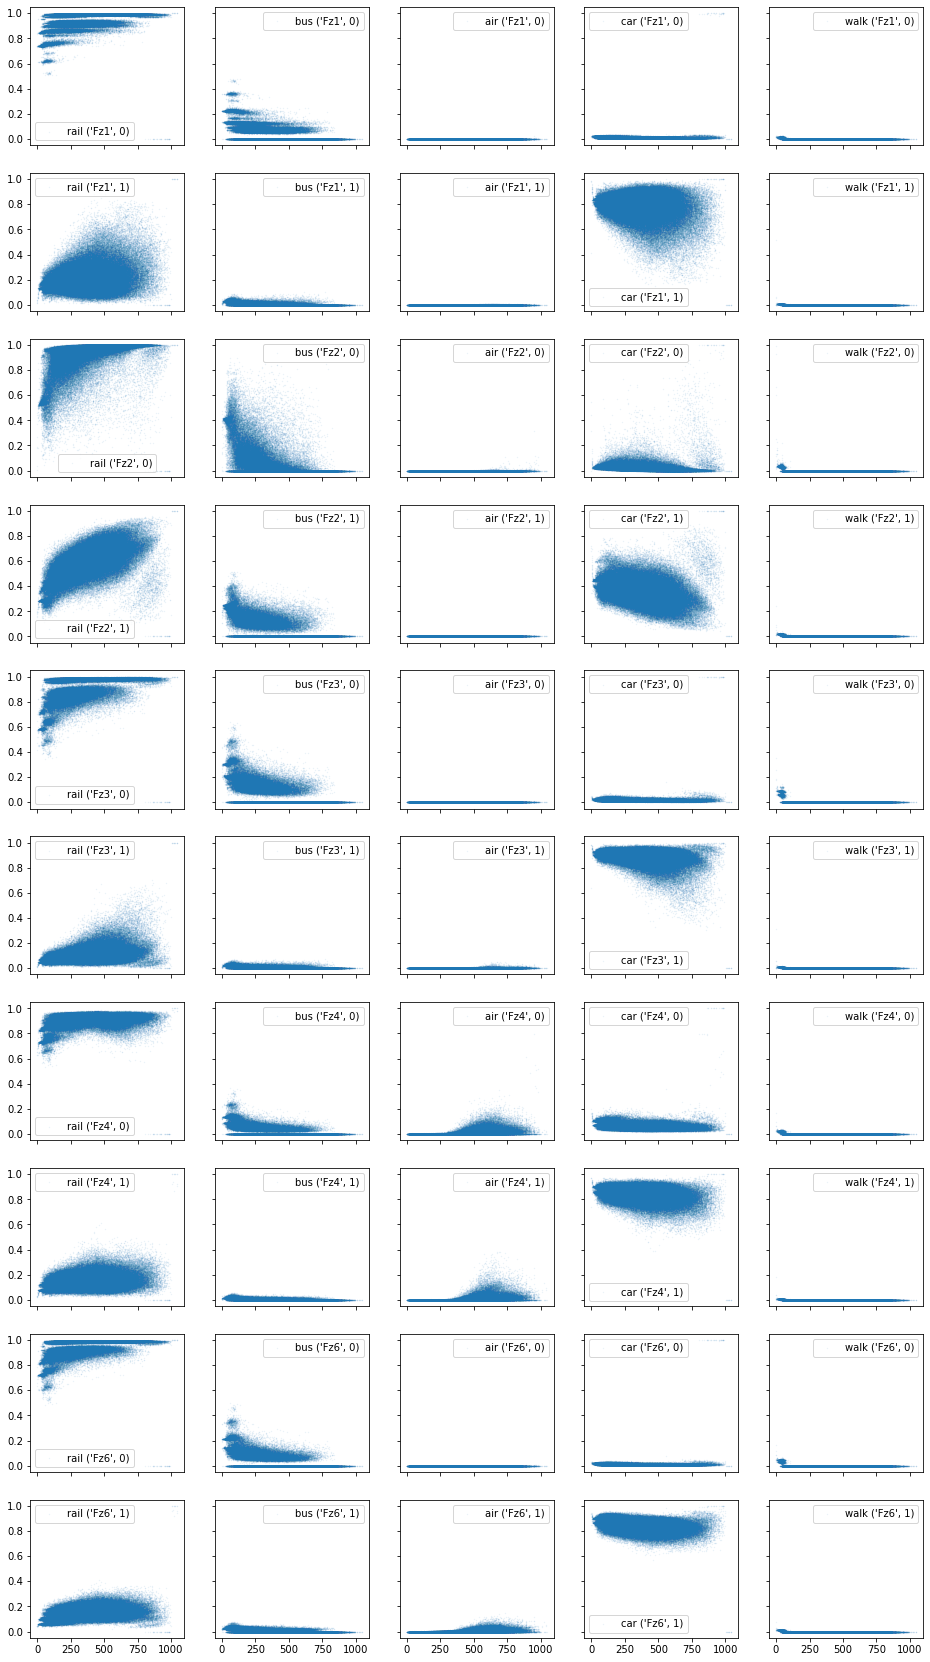

In [32]:
# Distance-distribution of probabilities
if manual:
    merged = sm.probabilities.merge(car.car_los[['origin', 'destination', 'length']],
                                    on=['origin', 'destination'], how='inner')
    fig, ax = plt.subplots(nrows=len(segments), ncols=len(route_types),
                           sharex='all', sharey='all', figsize=(16,len(segments)*3))
    for j, mode in zip(range(len(route_types)), route_types):
        for i, seg in zip(range(len(segments)), segments):
            x = merged.loc[merged['segment']==seg, 'length'] / 1000
            y = merged.loc[merged['segment']==seg, mode]
            ax[i,j].scatter(x, y, marker='o', s=.15, alpha=.1, label=mode+' '+seg)
            #p = np.poly1d(np.polyfit(x, y, deg=3))
            #ax[i,j].plot(x, p(x), linestyle='', marker='o', markersize=.5, color='grey', label=mode+' '+seg)
            ax[i,j].legend()